## Excitation Energy Calculation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot3 as uproot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

### Opening the reaction data file

In [3]:
InputFile = uproot.open("InputFile/QQQ5DataNew.root")
InputFile.keys()
InputTree=InputFile["Q5Tree"]
InputTree.keys()
InputTree.arrays(["QQQ5Energy","QQQ5Angle","ExcitationEnergy"])
df = InputTree.pandas.df(["QQQ5Energy*","QQQ5Angle*","ExcitationEnergy*"])
df['QQQ5Energy'] = 1000 * df['QQQ5Energy']
df.head()

,QQQ5Energy,QQQ5Angle,ExcitationEnergy
entry,,,
0,0.897734,155.262405,12.149085
1,0.628713,159.293854,13.080540
2,1.087449,137.446548,12.461211
3,0.650817,139.940186,13.741109
4,0.935666,135.778900,13.030253


## Preprocessing

In [4]:
#Preprocessing using MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1))
df[['QQQ5Energy','QQQ5Angle']] = scaling.fit_transform(df[['QQQ5Energy','QQQ5Angle']])
df_X = df.iloc[:, 0:2]
df_Y = df.iloc[:, 2:]

#Making train and test data
X_train, X_test, Y_train, Y_test = train_test_split(df_X,df_Y,test_size=0.3)

### Sequential model with 1 hidden layers

In [5]:
#Layers
inputs=Input(shape=(X_train.shape[1],)) 
x=Dense(16,activation='relu') (inputs)
#x=Dropout(0.1)(x) #Not over fitting, so not using Dropout
predictions=Dense(1) (x)

#Model
model=Model(inputs=inputs, outputs=predictions)
model.summary()

#Compile
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='mse',metrics=["mape"])

mcp_save = ModelCheckpoint('Model.h5', save_best_only=True, verbose=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


### Fitting

In [6]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, callbacks=[mcp_save])

Train on 337838 samples, validate on 144788 samples
Epoch 1/20
336160/337838 [============================>.] - ETA: 0s - loss: 4.6952 - mean_absolute_percentage_error: 21.0952
Epoch 00001: val_loss improved from inf to 0.01715, saving model to Model.h5
337838/337838 [==============================] - 11s 33us/sample - loss: 4.6719 - mean_absolute_percentage_error: 21.0015 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 2.3020
Epoch 2/20
337536/337838 [============================>.] - ETA: 0s - loss: 0.0129 - mean_absolute_percentage_error: 4.9218
Epoch 00002: val_loss improved from 0.01715 to 0.01241, saving model to Model.h5
337838/337838 [==============================] - 11s 34us/sample - loss: 0.0128 - mean_absolute_percentage_error: 4.9181 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 3.0624
Epoch 3/20
337120/337838 [============================>.] - ETA: 0s - loss: 0.0124 - mean_absolute_percentage_error: 5.3819
Epoch 00003: val_loss did not improve from 0.0

### Learning Curves

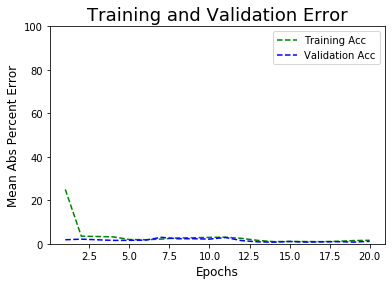

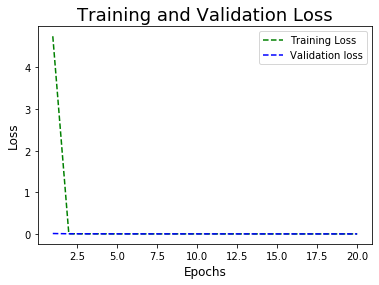

In [23]:
#Display of curves of loss and accuracy during training
loss = history.history['loss']
val_loss = history.history['val_loss']
mape = history.history['mean_absolute_percentage_error']
val_mape = history.history['val_mean_absolute_percentage_error']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, mape, 'g--', label='Training Acc')
plt.plot(epochs, val_mape, 'b--', label='Validation Acc')
plt.title('Training and Validation Error',fontsize=18)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Mean Abs Percent Error',fontsize=12)
plt.ylim(0,100)
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g--',label='Training Loss')
plt.plot(epochs, val_loss,'b--', label='Validation loss')
plt.title('Training and Validation Loss',fontsize=18)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.legend()
plt.show()

### Excitation Energy Prediction

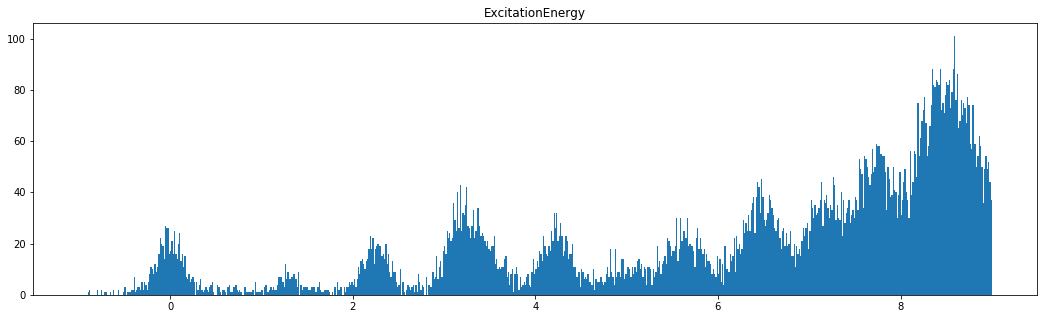

In [28]:
Y_predicted = model.predict(X_test)
df_Y_predicted = pd.DataFrame(Y_predicted, columns=['ExcitationEnergy'],index=X_test.index.copy())
hist = df_Y_predicted[['ExcitationEnergy']].hist(bins=700, figsize = (18,5), range=(-1, 9), grid=False)

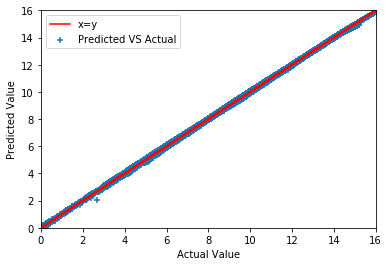

In [52]:
plt.scatter(Y_test,df_Y_predicted['ExcitationEnergy'],marker='+',label="Predicted VS Actual")
plt.plot(Y_test, Y_test, color='red',label = 'x=y')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.xlim(0,16)
plt.ylim(0,16)
plt.legend()